In [1]:
import math
import matplotlib as mp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import phate
import pygam as pg
import scanpy as sc
import scipy
import umap

from matplotlib import cm
from matplotlib.text import Annotation
from matplotlib.font_manager import FontProperties
from sklearn.manifold import TSNE

import warnings
from train_metric import train_metric_learner

import numpy as np
import scanpy as sc
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Trajectory Visualization
from sklearn.neighbors import NearestNeighbors

from models.ti.connectivity import compute_directed_cluster_connectivity, compute_undirected_cluster_connectivity
from models.ti.graph import compute_trajectory_graph, compute_connectivity_graph, compute_trajectory_graph_v2
from utils.plot import plot_connectivity_graph, plot_trajectory_graph, plot_connectivity_graph_with_gene_expressions
from utils.util import get_start_cell_cluster_id

from matplotlib import cm
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from models.ti.pseudotime import compute_pseudotime
from models.ti.pseudotime_v2 import compute_pseudotime

from utils.plot import plot_trajectory_graph_v2
from utils.plot import plot_pseudotime
from anndata import AnnData as am

from utils.plot import plot_lineage_trends

from utils.plot import generate_plot_embeddings, plot_gene_expression, plot_embeddings, plot_clusters

from utils_test import *

random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)

/home/ajita/anaconda3/envs/margaret/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


import os
os.getcwd() #Hs-alpha_merged_human
os.chdir("/data/Ajita/Islet/Margaret/margaret")

data_path = "/data/Ajita/Islet/data/"

adata_ = sc.read(data_path + "beta_all_population_dataSep12.h5ad")

start_ids = adata_[adata_.obs['cluster_name'] == "Mm-Progenitor"].obs_names.to_list()


/home/ajita/anaconda3/envs/margaret/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,


"""
adata.obs_names = adata.obs_names.astype(str)
adata.var_names = adata.var_names.astype(str)
adata.write_h5ad("./Figures/Run_10Mar/Margaret_run.h5ad")
"""

pd.DataFrame(adata.obsm["metric_embedding"]).to_csv("./Figures/Run_10Mar/metric_embedding.csv")


In [3]:
adata = sc.read_h5ad("./Figures/beta_Run_10Mar/Margaret_run.h5ad")

In [4]:

X_embedded = generate_plot_embeddings(adata.obsm['metric_embedding'], method='umap', random_state=random_seed) #preprocessed_data
adata.obsm['X_met_embedding'] = X_embedded #preprocessed_data


plot_embeddings(X_embedded, s=12)#labels

adata.uns['metric_clustering_scores'] = 0


Runtime for generate_plot_embeddings(): 68.15998411178589


['Mm-Progenitor' 'Mm-Beta 1' 'Mm-Beta 2' 'Mm-Beta 3']


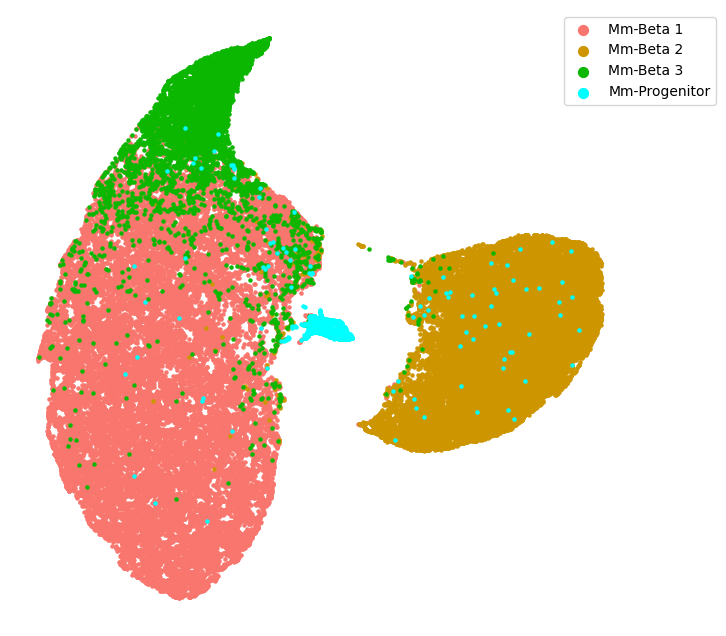

In [6]:


color_map_week = {
"14W" : "#320E3B", #aqua	#00FFFF
"8W" : "#7F96FF", #springgreen	#00FF7F	RGB(0,255,127)
"22W" : "#A6CFD5",#warmgrey	#808069	RGB(128,128,105)
"30W" :"#DBFCFF"#brown1	#FF4040	RGB(255,64,64) red
}

color_map = {
"Mm-Progenitor" : "#00FFFF", #aqua	#00FFFF
"Mm-Beta 1-1" : "#DC143C",#crimson	#DC143C	RGB(220,20,60)
"Mm-Beta 1-2" : "#9C661F", #brick	#9C661F	RGB(156,102,31)
"Mm-Beta 2-1" : "#00FF7F", #springgreen	#00FF7F	RGB(0,255,127)
"Mm-Beta 2-2" : "#FF6103",#cadmiumorange	#FF6103	RGB(255,97,3)
"Mm-Beta 3-1" : "#458B00",#chartreuse4	#458B00	RGB(69,139,0)
"Mm-Beta 3-2" : "#0000FF", #blue	#0000FF	RGB(0,0,255)
"Mm-Beta 3-3" : "#68228B",#darkorchid4	#68228B	RGB(104,34,139)
"Mm-Gamma 1" : "#8B7500",#gold4	#8B7500	RGB(139,117,0)
"Mm-Gamma 2" : "#030303",#gray1	#030303	RGB(3,3,3)
"Mm-Alpha 1" : "#FF00FF", #magenta	#FF00FF	RGB(255,0,255)
"Mm-Alpha 2" : "#63B8FF",#steelblue1	#63B8FF	RGB(99,184,255)
"Mm-Delta 1" : "#FFFF00",#yellow1	#FFFF00	RGB(255,255,0)
"Mm-Delta 2" : "#808069",#warmgrey	#808069	RGB(128,128,105)
"Mm-Delta 3" :"#FF4040"#brown1	#FF4040	RGB(255,64,64) red
}
"""
color_map = {
   "Mm-Alpha 1" : "#FF3864", # pink,
    "Mm-Alpha 2" : "#261447", # violet
    "Mm-Progenitor" : "#F39C6B" # peach
}
"""

color_map_diet = {
   "HFD" : "#e76f51", # pink,
    "RC" : "#2a9d8f", # violet
}

plot_clusters(adata,
    cluster_key = 'cluster_name',
    embedding_key = 'X_met_embedding',
    color_map = color_map, cmap='plasma',
    legend_kwargs={
        'loc': 'upper right',
        'bbox_to_anchor': (1.15, 1),
        'fontsize': 'medium'
    },
    s=5,
    save_path = './Figures/beta_Run_10Mar/ground_clusters.png',
    save_kwargs={
        'dpi': 300,
        'bbox_inches': 'tight',
        'transparent': True
    },
)



In [7]:

communities = adata.obs['metric_clusters'].to_numpy().astype(np.int) #preprocessed_data

X = adata.obsm['metric_embedding'] #preprocessed_data

n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
adj_dist = nbrs.kneighbors_graph(X, mode="distance")
adj_conn = nbrs.kneighbors_graph(X)

In [8]:
print (communities)
adata.obs['communities'] = communities

color_map_communities = {
    0: '#D2BD9E',
    1: '#DD907D',
    2: '#C8DC9E',
    3: '#9EDBCE',
    4: '#B9BAE6',
    5: '#44BEFF',
    6: '#EC5547',
    7: '#5B4D66',
    8: '#329A64',
    9: '#A77F19',
    10: '#F28482',
    11: '#9FA0DC',
    12: '#CC5639',
    13: '#0077b6',
    14: '#3E1429',
    15: '#EDD188',
    16: '#84B5D1',
    17: '#466EC3',
    18: '#BD9FBD',
    19: '#134F60',
    20: '#7C99A4',
    21: '#DFAC29',
    22: '#DB9ED0',
    23:  '#40545C',
}

plot_clusters(adata,
    cluster_key = 'communities',
    embedding_key = 'X_met_embedding',
    color_map = color_map_communities, cmap='plasma',
    legend_kwargs={
        'loc': 'upper right',
        'bbox_to_anchor': (1.15, 1),
        'fontsize': 'large'
    },
    s=5,
    #save_path='./Figures/Run_10Mar/predicted_clusters.png',
    save_kwargs={
        'dpi': 300,
        'bbox_inches': 'tight',
        'transparent': True
    },
)

[23 23 23 ... 18 18 22]


Runtime for compute_undirected_cluster_connectivity(): 1.9952516555786133
Runtime for compute_connectivity_graph(): 0.013140678405761719
Runtime for compute_directed_cluster_connectivity(): 0.5221288204193115


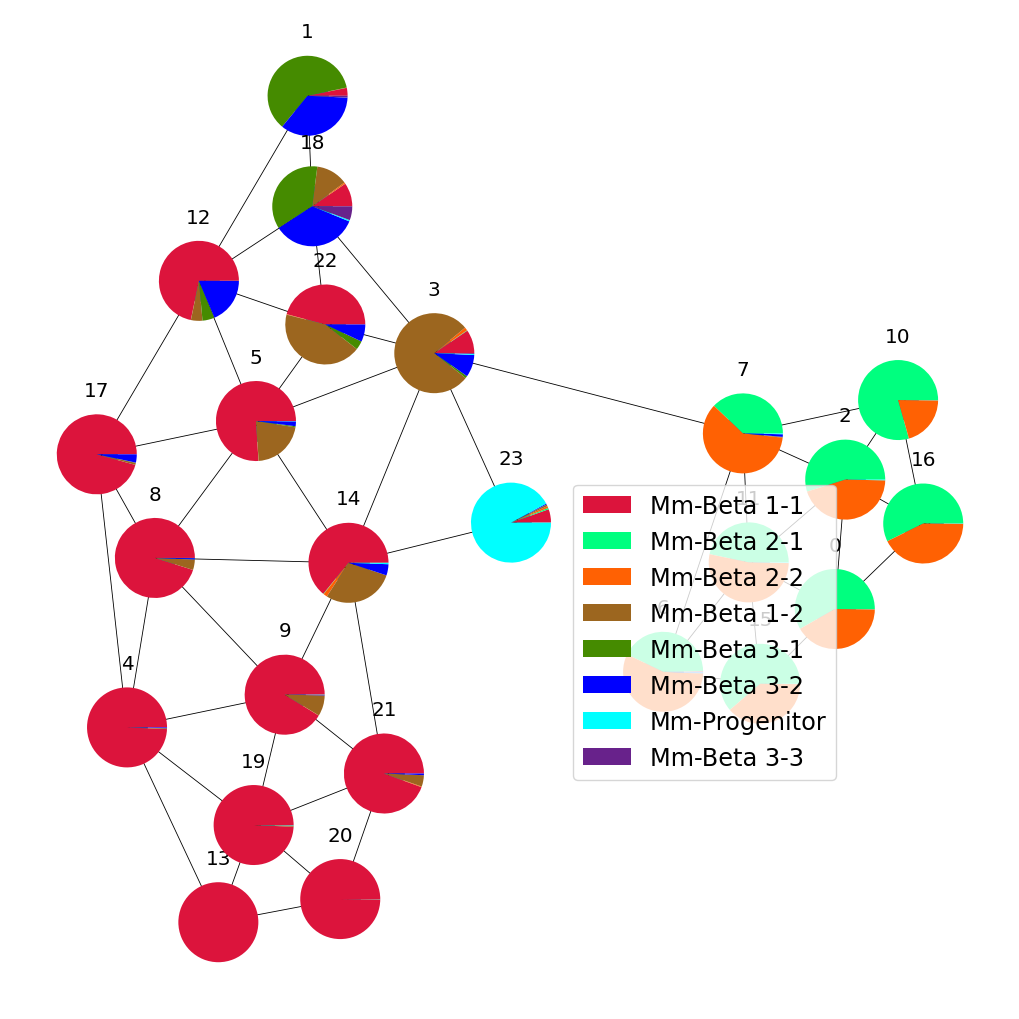

In [9]:

"""
#start_cluster_ids = {13}
#start_cell_ids = start_progenitor_ids
"""
def plot_connectivity_graph_new(
    adata,
    embeddings,
    communities,
    cluster_connectivities,
    start_cell_ids=None,
    mode="undirected",
    cmap="YlGn",
    figsize=(10, 10),
    node_size=800,
    font_color="black",
    start_node_color=None,
    node_color=None,
    title=None,
    save_path=None,
    save_kwargs={},
    offset=0,
    **kwargs,
):
    g, node_positions = compute_connectivity_graph(
        embeddings, communities, cluster_connectivities, mode=mode
    )

    if start_cell_ids is not None:
        start_cell_ids = (
            start_cell_ids if isinstance(start_cell_ids, list) else [start_cell_ids]
        )
    else:
        start_cell_ids = []

    start_cluster_ids = set([communities.loc[id] for id in start_cell_ids])

    colors = np.unique(communities)
    
    if node_color is not None:
        colors = []
        for c_id in np.unique(communities):
            if c_id in start_cluster_ids and start_node_color is not None:
                colors.append(start_node_color)
            else:
                colors.append(node_color)

    # Draw the graph
    fig = plt.figure(figsize = figsize)
    ax = plt.axes([0,0,1,1])
    
    if title is not None:
        plt.title(title)
        
    plt.axis("off")
    
    edge_weights = [3*(offset) for _, _, w in g.edges.data("weight")]
    
    nx.draw_networkx(
        g,
        pos=node_positions,
        #cmap=cmap,
        #node_color=colors,
        font_color=font_color,
        node_size=node_size,
        arrowsize = 30,
        width=edge_weights,
        labels = None,
        font_size = 10,
        **kwargs,
    )
    
    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform

    piesize = 0.1 # pie size...
    p2 = piesize/2.0
    cs = cm.Set1(np.arange(15)/15.)
    
    for n in g:
        
        xx,yy = trans(node_positions[n]) # figure coordinates
        xa,ya = trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        plt.title(n, fontsize="x-large", loc = "center")
        a.set_aspect('equal')
        
        adata_node = adata[adata.obs['metric_clusters'] == n].copy()
        keys = adata.obs['cluster_name'].value_counts().keys()
        fracs = []
        colour_list = []
        
        for key in keys:
            fracs_keys = adata_node.obs['cluster_name'].value_counts().keys() 
            colour_list += [color_map[key]]
            if key in fracs_keys:
                fracs += [adata_node.obs['cluster_name'].value_counts()[key]]
            else:
                fracs += [0]
                
        fracs = np.array(fracs)/adata_node.shape[0] #[15,30,35, 10, 10]
        a.pie(fracs, colors = colour_list) # labels = keys
        
    #plt.legend(keys,bbox_to_anchor = (0.15, 6), fontsize = "xx-large") # loc = "lower left", bbox_to_anchor = (0.65, 1.25)
    plt.legend(keys, loc = "upper left", fontsize = "xx-large", bbox_to_anchor = (1, 1))
    
    if save_path is not None:
        plt.savefig(save_path, **save_kwargs)


# z_threshold can be increased for less no of edges..0.1 -> 0.6
un_connectivity, un_z_score = compute_undirected_cluster_connectivity(communities, adj_conn, z_threshold=0.1) # z_threshold can be inreased for less no of edges...0.6
pd.DataFrame(un_z_score)

plot_connectivity_graph_new(adata, adata.obsm['X_met_embedding'], communities, un_connectivity, mode='undirected', 
                            offset=0.2,     
                            #save_path='./Figures/Run_10Mar/undirected.png',
                            save_kwargs={
                            'dpi': 300,
                            'bbox_inches': 'tight',
                            'transparent': True
                            }) #preprocessed_data

connectivity, z_score = compute_directed_cluster_connectivity(communities, adj_conn, threshold=0.8)



Manually add the cluster number by seeing the plot.

In [11]:

def get_start_cell_cluster_id(data, start_cell_ids, communities):
    
    start_cluster_ids = set()
    start_progenitor_ids = set()
    
    obs_ = data.obs_names
    for cell_id in start_cell_ids:
        
        start_cell_idx = np.where(obs_ == cell_id)[0][0]
        start_cell_cluster_idx = communities[start_cell_idx]
        start_cluster_ids.add(start_cell_cluster_idx)
        if start_cell_cluster_idx == 23:# or start_cell_cluster_idx == 8:  # earlier: 17
            start_progenitor_ids.add(cell_id)
            
    return start_cluster_ids, start_progenitor_ids


start_cell_ids = start_ids #['PSCs']
start_cluster_ids, start_progenitor_ids = get_start_cell_cluster_id(adata, start_cell_ids, communities) # can take multiple start cells.. #preprocessed_data
print ("start_cluster_ids", start_cluster_ids)
print ("start_ids", len(start_progenitor_ids))

print ("start ids", len(start_ids))
start_cluster_ids, progenitor_ids = get_start_cell_cluster_id(adata, start_progenitor_ids, communities) 
print (start_cluster_ids)

start_cell_ids = start_progenitor_ids

start_cluster_ids {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 23}
start_ids 967
start ids 1071
{23}


In [12]:
# v2 pseudotime
G_undirected, node_positions = compute_connectivity_graph(adata.obsm['X_met_embedding'], adata.obs['metric_clusters'], un_connectivity) #preprocessed_data
adj_cluster = nx.to_pandas_adjacency(G_undirected)
pseudotime = compute_pseudotime(adata, start_cell_ids, adj_dist, adj_cluster) #preprocessed_data


Runtime for compute_connectivity_graph(): 0.028117656707763672
Runtime for compute_pseudotime(): 532.5602083206177


In [13]:
adata

AnnData object with n_obs × n_vars = 64306 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'decontX_contamination', 'decontX_clusters', 'sizeFactor', 'Dataset', 'Replicate', 'Week', 'Diet', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.05', 'seurat_clusters', 'cluster_name', 'cluster_name_rename', 'RNA_snn_res.0.06', 'Diet_Week', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'seurat_clusters_dataset', 'cluster_rename', 'RNA_snn_res.0.5', 'RNA_snn_res.0.02', 'RNA_snn_res.0.6', 'RNA_snn_res.0.4', 'RNA_snn_res.0.15', 'RNA_snn_res.0.125', 'RNA_snn_res.0.11', 'RNA_snn_res.0.3', 'RNA_snn_res.5', 'RNA_snn_res.0.18', 'RNA_snn_res.0.25', 'RNA_snn_res.0.8', 'RNA_snn_res.1.5', 'RNA_snn_res.0.13', 'RNA_snn_res.0.7', 'RNA_snn_res.0.9', 'RNA_snn_res.0.005', 'RNA_snn_res.0.01', 'RNA_snn_res.0.03', 'RNA_snn_res.0.04', 'RNA_snn_res.0.07', 'RNA_snn_res.0.08', 'RNA_snn_res.0.09', 'cell_diet

MAGIC imputed data not found. Using raw counts instead
Runtime for compute_connectivity_graph(): 0.023174762725830078


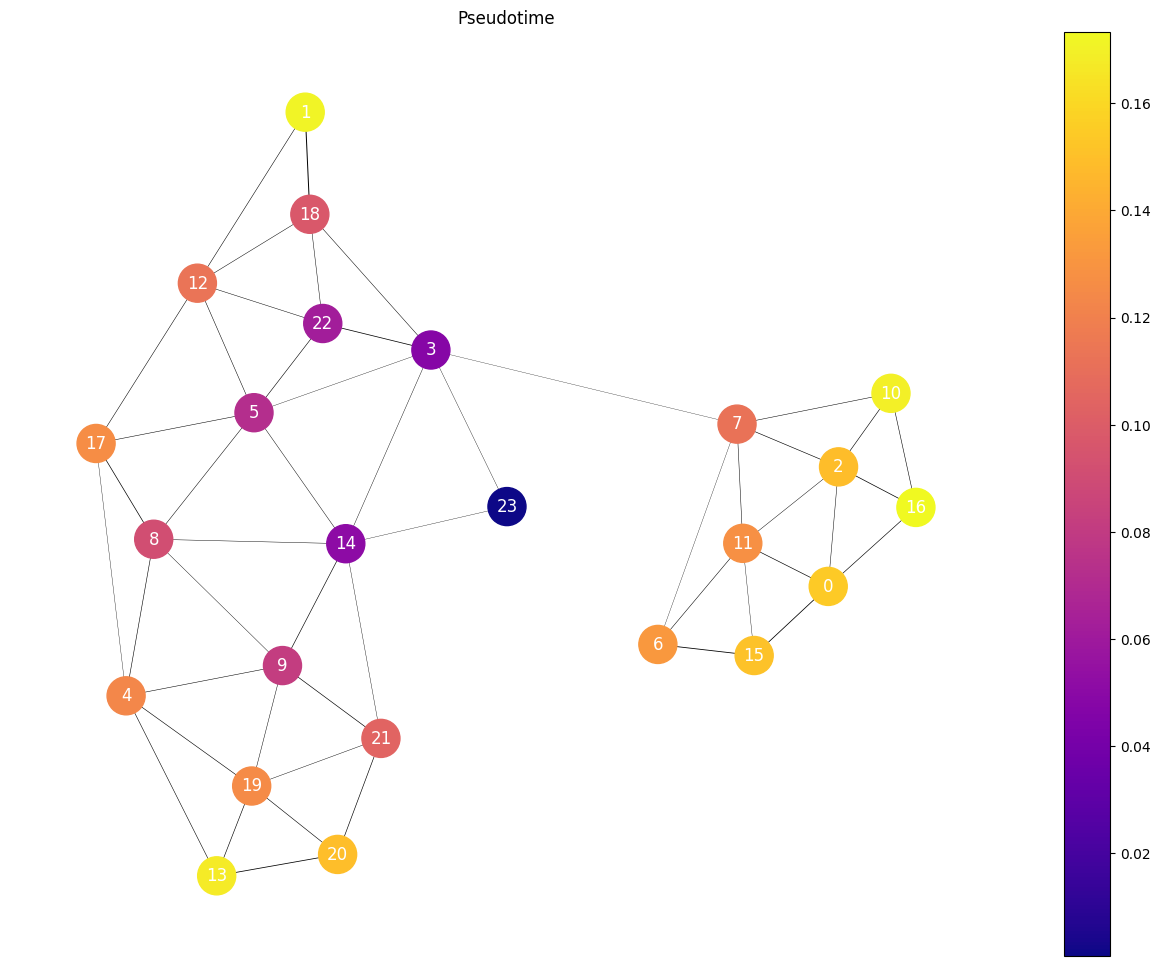

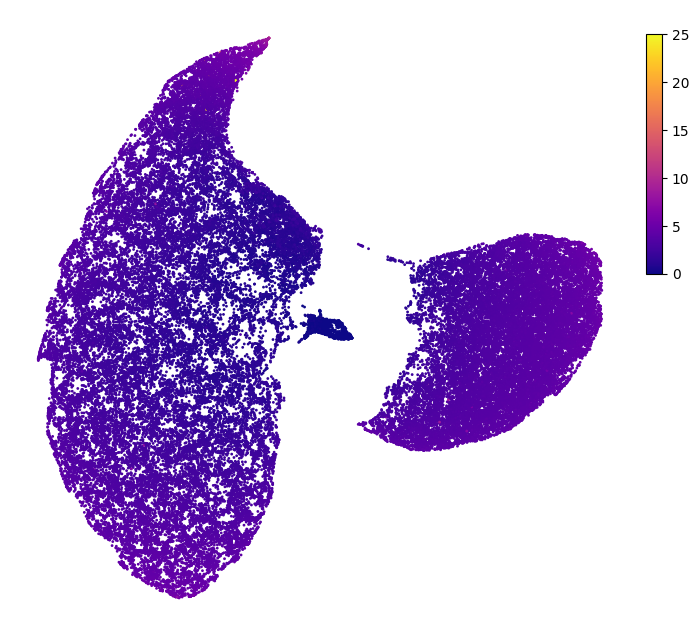

In [21]:
def plot_connectivity_graph_pseudotime(
    ad,
    cluster_connectivities,
    diff_potential,
    embedding_key="X_met_embedding",
    comm_key="metric_clusters",
    magic_key="X_magic",
    mode="undirected",
    cmap="YlGn",
    figsize=(16, 12),
    node_size=400,
    font_color="black",
    title=None,
    save_path=None,
    save_kwargs={},
    offset=0,
    **kwargs,
):
    try:
        X_embedded = ad.obsm[embedding_key]
        #X_embedded = ad.obs[embedding_key]
    except KeyError:
        raise Exception(f"Key {embedding_key} not found in {ad}")

    try:
        communities = ad.obs[comm_key]
    except KeyError:
        raise Exception(f"Key {comm_key} not found in {ad}")

    try:
        X_imputed = pd.DataFrame(
            ad.obsm[magic_key], index=ad.obs_names, columns=ad.var_names
        )
    except KeyError:
        print("MAGIC imputed data not found. Using raw counts instead")
        X_imputed = ad.to_df()


    g, node_positions = compute_connectivity_graph(
        X_embedded, communities, cluster_connectivities, mode=mode
    )

    # Normalize and compute cluster wise mean expression of the gene
    X_gene = diff_potential
    X_gene = (X_gene - X_gene.min()) / (X_gene.max() - X_gene.min())
    gene_exprs = []
    for cluster_id in np.unique(communities):
        ids = communities == cluster_id
        mean_gene_expr = X_gene.loc[ids].mean()
        gene_exprs.append(mean_gene_expr)

    # Draw the graph
    plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    edge_weights = [offset + w for _, _, w in g.edges.data("weight")]
    nx.draw_networkx(
        g,
        pos=node_positions,
        cmap=cmap,
        node_color=gene_exprs,
        font_color=font_color,
        node_size=node_size,
        width=edge_weights,
        **kwargs,
    )
    # Setup color bar
    vmin = np.min(gene_exprs)
    vmax = np.max(gene_exprs)
    normalize = mp.colors.Normalize(vmin=vmin, vmax=vmax)
    cax, _ = mp.colorbar.make_axes(plt.gca())
    mp.colorbar.ColorbarBase(cax, norm=normalize, cmap=plt.get_cmap(cmap))

    if save_path is not None:
        plt.savefig(save_path, **save_kwargs)
    plt.show()    

plot_connectivity_graph_pseudotime(adata, un_connectivity, adata.obs["metric_pseudotime_v2"],\
                                                    embedding_key="X_met_embedding",mode="undirected", font_color='white', \
        cmap='plasma', offset=0.2, node_size=750, font_size=12, comm_key='metric_clusters', 
                                                    title = "Pseudotime",
                                                    save_path='./Figures/beta_Run_10Mar/directed_pseudotime.png',
                                                    save_kwargs={
                                                        'dpi': 300,
                                                        'bbox_inches': 'tight',
                                                        'transparent': True
                                                    })


plot_pseudotime(
    adata, #preprocessed_data
    embedding_key="X_met_embedding",
    pseudotime_key="metric_pseudotime_v2",
    s=1,
    cmap='plasma',
    figsize=(8, 8),
    cb_axes_pos=[0.92, 0.55, 0.02, 0.3],
    #save_path='./Figures/Run_10Mar/pseudotime_v2.png',
    save_kwargs={
        'dpi': 300,
        'bbox_inches': 'tight',
        'transparent': True
    }
)


In [22]:
# Creating a single time point for HFD as well as RC.

adata.obs["week_updated"] = adata.obs["Dataset"].str[:-3]
adata.obs["week_updated"] = adata.obs['week_updated'].str.replace("HFD-8W", "RC-14W")
adata.obs["week_updated"] = adata.obs['week_updated'].str.replace("HFD-16W", "RC-22W")
adata.obs["week_updated"] = adata.obs['week_updated'].str.replace("HFD-24W", "RC-30W")
adata.obs['week_updated'] = adata.obs['week_updated'].str[3:]
adata.obs["week_updated"] = adata.obs['week_updated'].str.replace("-", "")

print (adata.obs['week_updated'].unique())

['14W' '22W' '30W' '8W']


In [61]:
adata.obs["cluster_name"].unique()

adata.obs["new_cluster_name"]= adata.obs["cluster_name"]
for s in ["-1", "-2", "-3"]:
    adata.obs["new_cluster_name"] = adata.obs['new_cluster_name'].str.replace(s,"")
    
print(adata.obs["new_cluster_name"].unique())

['Mm-Progenitor' 'Mm-Beta 1' 'Mm-Beta 2' 'Mm-Beta 3']


In [55]:
adata

AnnData object with n_obs × n_vars = 64306 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'decontX_contamination', 'decontX_clusters', 'sizeFactor', 'Dataset', 'Replicate', 'Week', 'Diet', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.05', 'seurat_clusters', 'cluster_name', 'cluster_name_rename', 'RNA_snn_res.0.06', 'Diet_Week', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'seurat_clusters_dataset', 'cluster_rename', 'RNA_snn_res.0.5', 'RNA_snn_res.0.02', 'RNA_snn_res.0.6', 'RNA_snn_res.0.4', 'RNA_snn_res.0.15', 'RNA_snn_res.0.125', 'RNA_snn_res.0.11', 'RNA_snn_res.0.3', 'RNA_snn_res.5', 'RNA_snn_res.0.18', 'RNA_snn_res.0.25', 'RNA_snn_res.0.8', 'RNA_snn_res.1.5', 'RNA_snn_res.0.13', 'RNA_snn_res.0.7', 'RNA_snn_res.0.9', 'RNA_snn_res.0.005', 'RNA_snn_res.0.01', 'RNA_snn_res.0.03', 'RNA_snn_res.0.04', 'RNA_snn_res.0.07', 'RNA_snn_res.0.08', 'RNA_snn_res.0.09', 'cell_diet

Runtime for compute_trajectory_graph_v2(): 0.04473161697387695
Runtime for compute_trajectory_graph_v2(): 0.04189777374267578
Runtime for compute_trajectory_graph_v2(): 0.042222023010253906
Runtime for compute_trajectory_graph_v2(): 0.035994529724121094
Runtime for compute_trajectory_graph_v2(): 0.04034733772277832


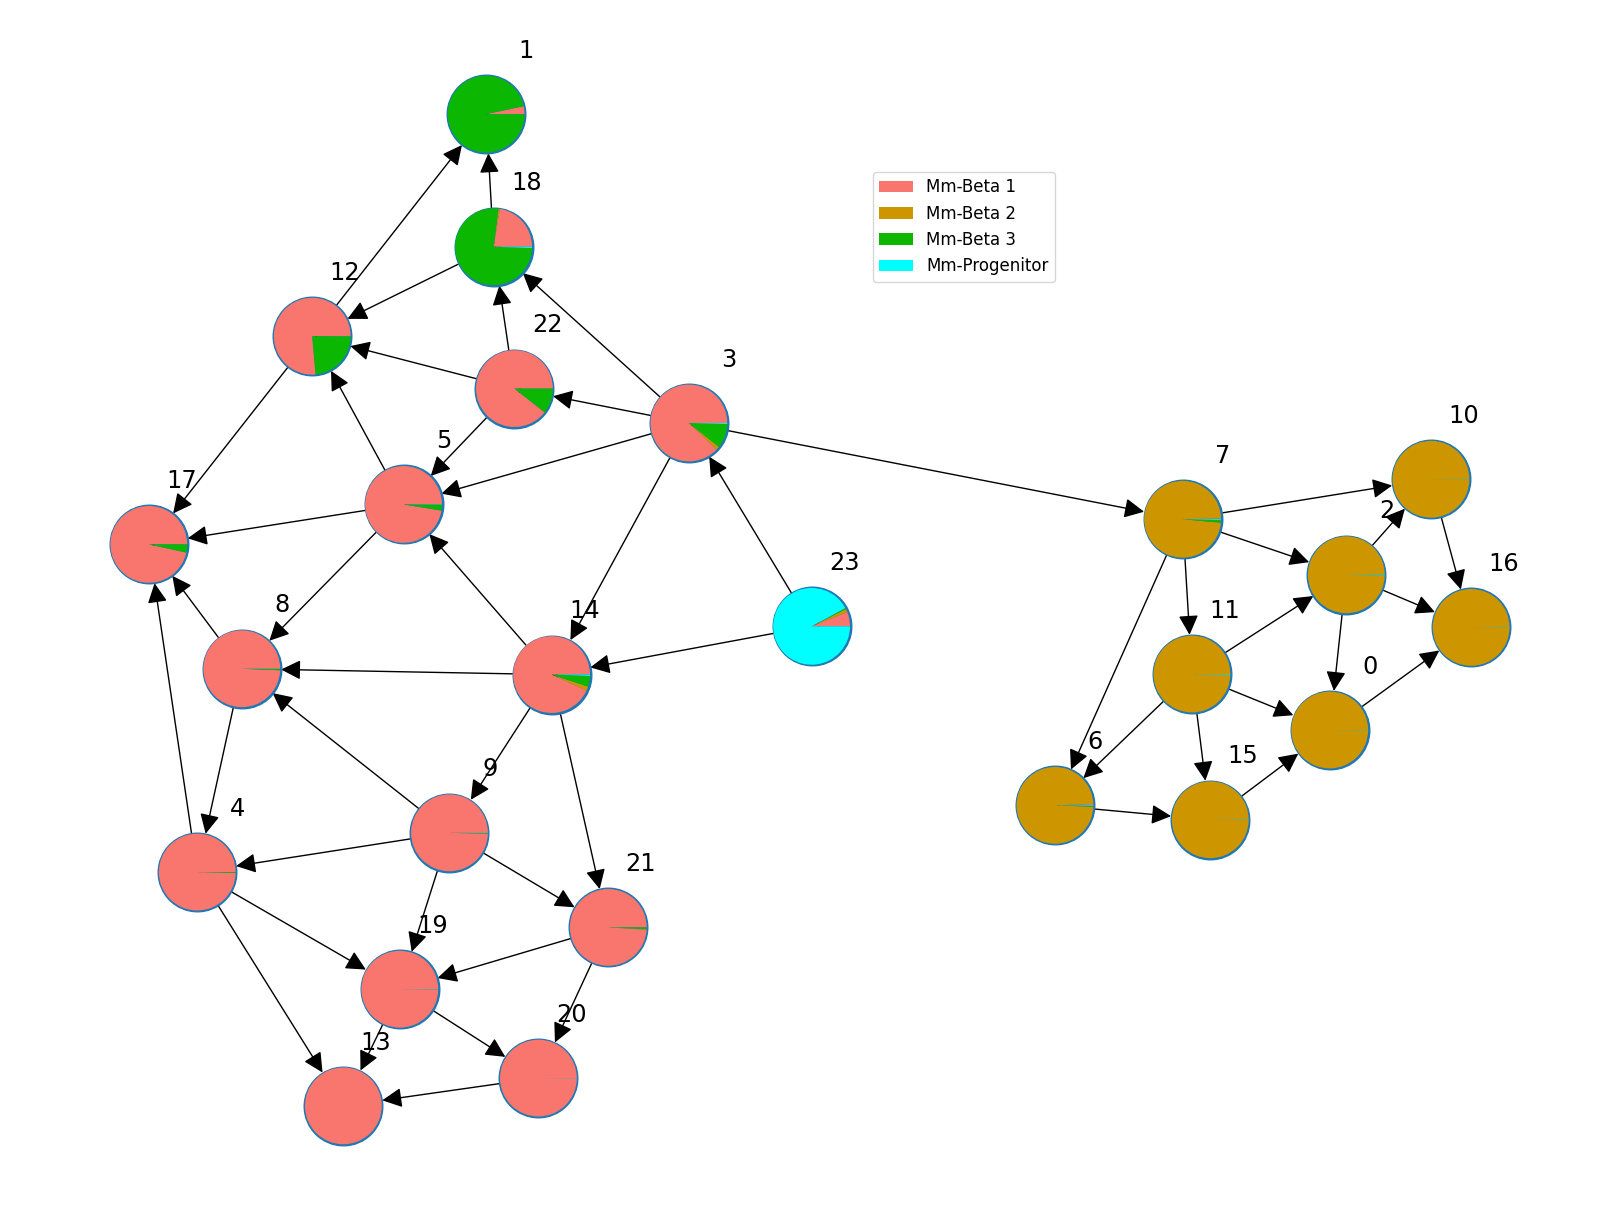

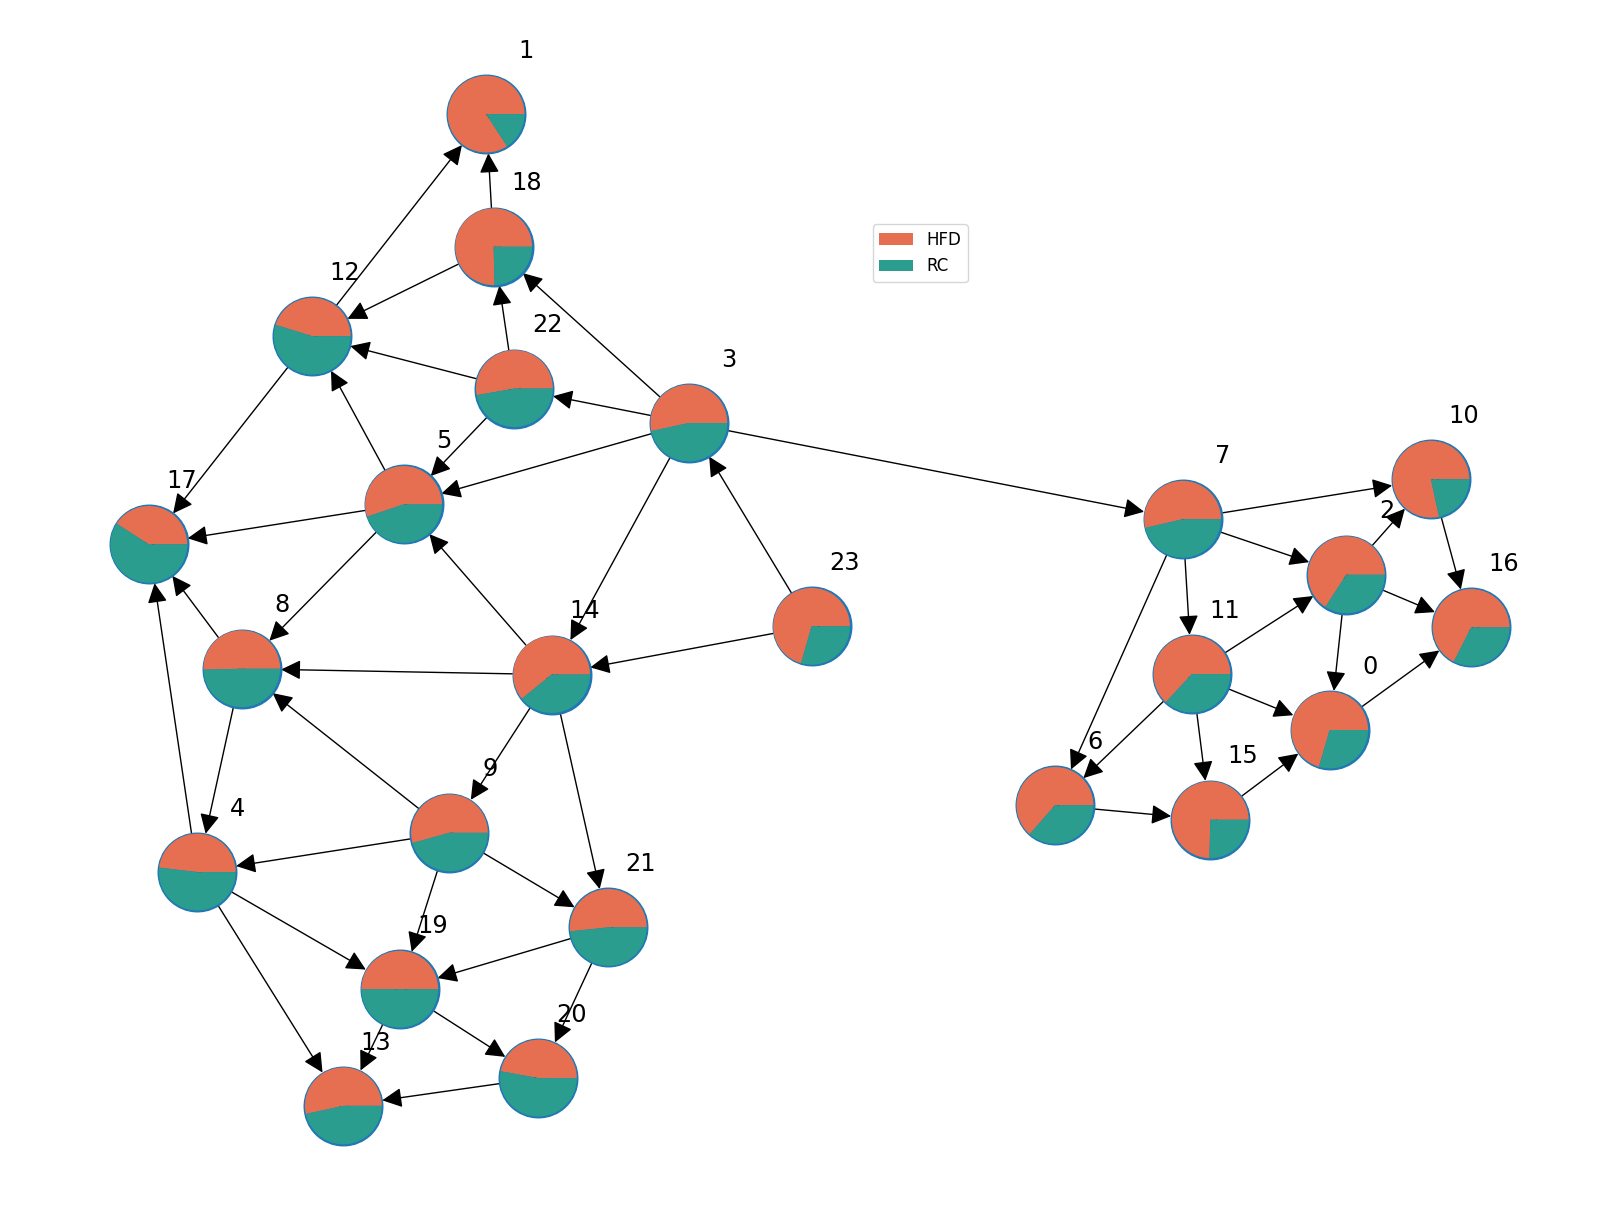

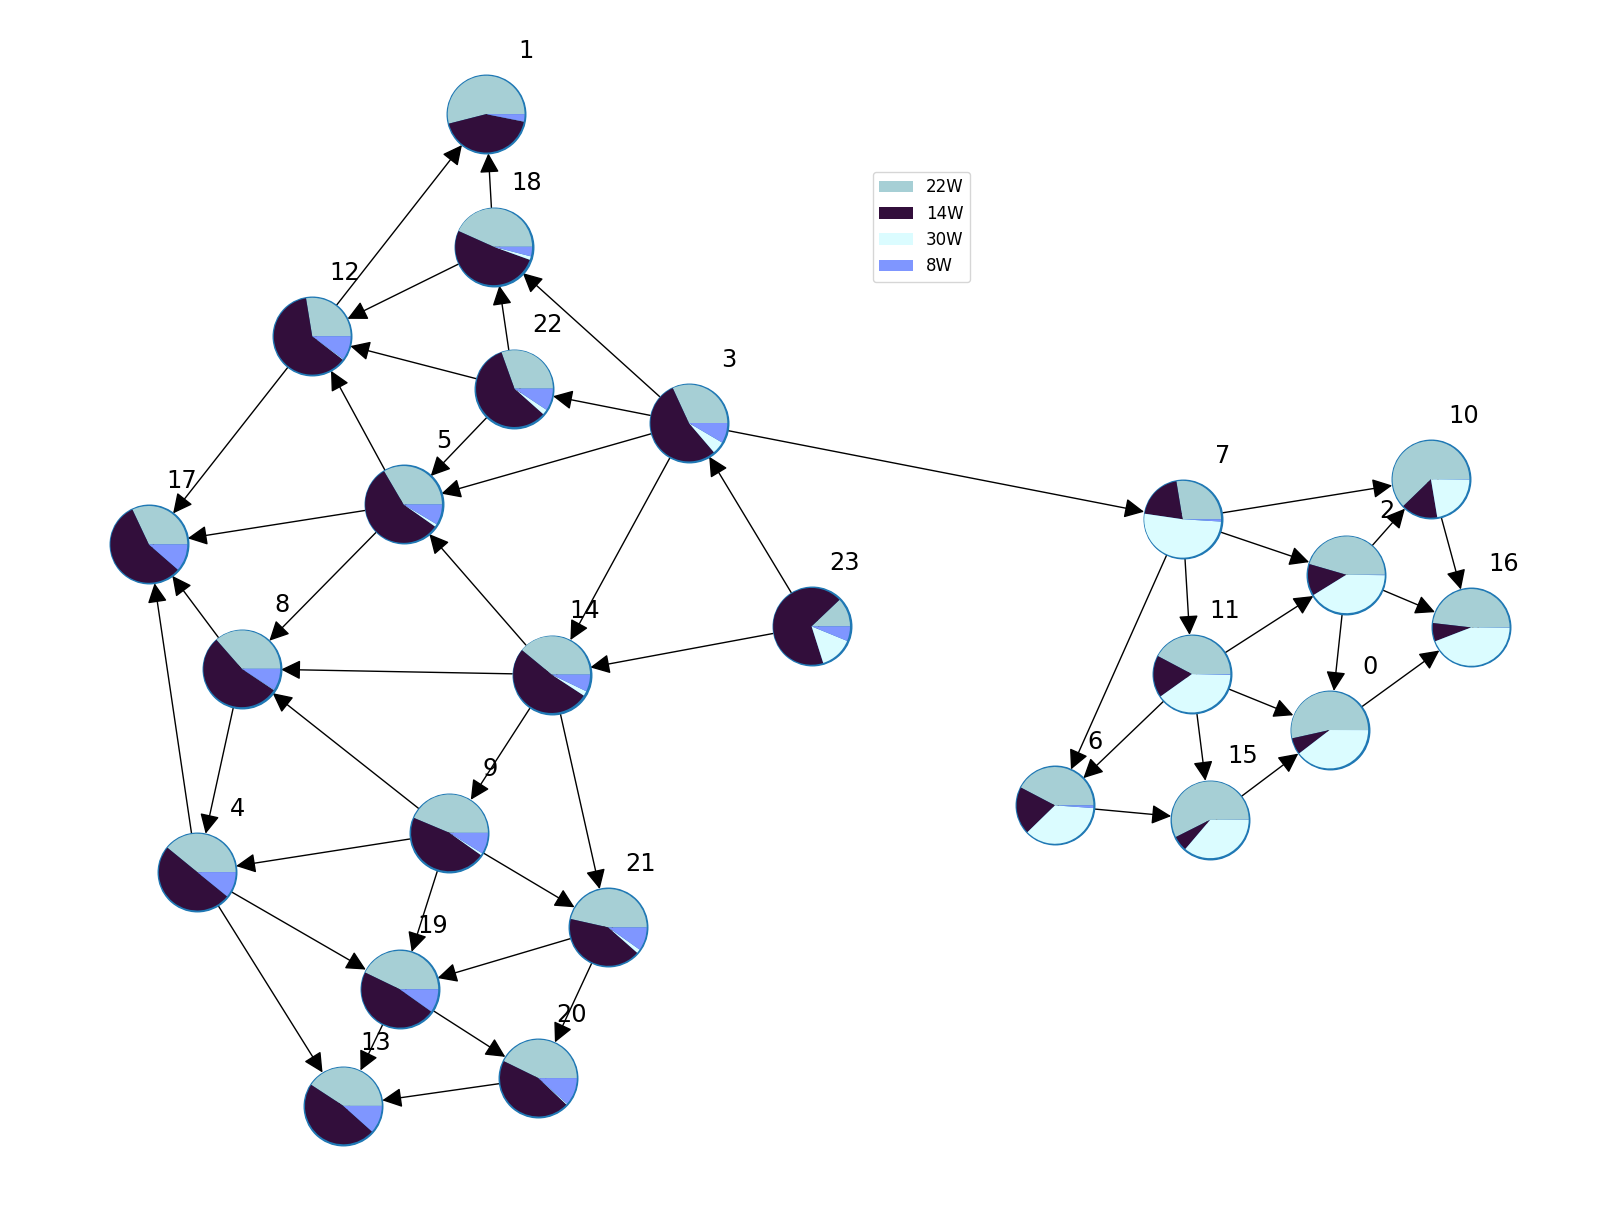

In [64]:
# Compute directed graph v2

color_map = {
"Mm-Progenitor" : "#00FFFF", #aqua	#00FFFF
"Mm-Beta 1" : "#F8766D",#crimson	#DC143C	RGB(220,20,60)

"Mm-Beta 2" : "#CD9600", #springgreen	#00FF7F	RGB(0,255,127)

"Mm-Beta 3" : "#0CB702"#chartreuse4	#458B00	RGB(69,139,0)

}

def plot_trajectory_graph_v2_new(
    pseudotime,
    adj_cluster,
    communities,
    d_connectivity,
    node_positions,
    pie_col,
    color_map,
    start_cell_ids=None,
    cmap="YlGn",
    figsize=(16, 12),
    node_size=3200,
    font_color="black",
    title=None,
    start_node_color=None,
    node_color=None,
    save_path=None,
    save_kwargs={},
    offset=10, #0, 2
    **kwargs,
):
    adj_g = compute_trajectory_graph_v2(
        pseudotime, adj_cluster, communities, d_connectivity
    )
    g = nx.from_pandas_adjacency(adj_g, create_using=nx.DiGraph)

    if start_cell_ids is not None:
        start_cell_ids = (
            start_cell_ids if isinstance(start_cell_ids, list) else [start_cell_ids]
        )
    else:
        start_cell_ids = []

    start_cluster_ids = set([communities.loc[id] for id in start_cell_ids])

    colors = np.unique(communities)
    
    if node_color is not None:
        colors = []
        for c_id in np.unique(communities):
            if c_id in start_cluster_ids and start_node_color is not None:
                colors.append(start_node_color)
            else:
                colors.append(node_color)

    # Draw the graph
    fig = plt.figure(figsize=figsize)
    ax = plt.axes([0,0,1,1])
    
    if title is not None:
        plt.title(title)
    plt.axis("off")
    
    edge_weights = [5*(offset) for _, _, w in g.edges.data("weight")]
    
    nx.draw_networkx(
        g,
        pos=node_positions,
        #cmap=cmap,
        #node_color=colors,
        font_color=font_color,
        node_size=node_size,
        arrowsize = 30,
        width=edge_weights,
        labels = None,
        font_size = 10,
        **kwargs,
    )
    
    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform

    piesize = 0.08 # 0.1, 0.05
    p2 = piesize/2.0
    cs = cm.Set1(np.arange(15)/15.)
    

    for n in g:
        xx,yy = trans(node_positions[n]) # figure coordinates
        xa,ya = trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        plt.title(n, fontsize = "xx-large", loc = "right")
        a.set_aspect('equal')
        
        adata_node = adata[adata.obs['metric_clusters'] == n].copy()
        keys = adata.obs[pie_col].value_counts().keys()
        fracs = []
        colour_list = []
        
        for key in keys:
            fracs_keys = adata_node.obs[pie_col].value_counts().keys() 
            colour_list += [color_map[key]]
            if key in fracs_keys:
                fracs += [adata_node.obs[pie_col].value_counts()[key]]
            else:
                fracs += [0]
                
        fracs = np.array(fracs)/adata_node.shape[0] # [15,30,35,10,10]
        a.pie(fracs, colors = colour_list) # labels = keys
        
    #plt.legend(keys,bbox_to_anchor = (0.65, 6.25), fontsize = "xx-large") #lower left", 
    plt.legend(keys, loc = "lower left", fontsize = "large", bbox_to_anchor = (1.05, 4))
    if save_path is not None:
        plt.savefig(save_path, **save_kwargs)

        
G_directed_v2 = compute_trajectory_graph_v2(pseudotime, adj_cluster, adata.obs['metric_clusters'], connectivity) # preprocessed_data

G_directed_v2 = compute_trajectory_graph_v2(pseudotime, adj_cluster, adata.obs['metric_clusters'], connectivity)

plot_trajectory_graph_v2_new(pseudotime, adj_cluster, adata.obs['metric_clusters'], connectivity, \
                             node_positions, offset=0.2, pie_col = "new_cluster_name", color_map = color_map,
                                save_path='./Figures/beta_Run_10Mar/new_directed_graph.png',
                                save_kwargs={
                                    'dpi': 300,
                                    'bbox_inches': 'tight',
                                    'transparent': True
                                })

plot_trajectory_graph_v2_new(pseudotime, adj_cluster, adata.obs['metric_clusters'], connectivity, \
                             node_positions, offset=0.2, pie_col = "Diet", color_map = color_map_diet,
                                save_path='./Figures/beta_Run_10Mar/diet_wise.png',
                                save_kwargs={
                                    'dpi': 300,
                                    'bbox_inches': 'tight',
                                    'transparent': True
                                })

plot_trajectory_graph_v2_new(pseudotime, adj_cluster, adata.obs['metric_clusters'], connectivity, \
                             node_positions, offset=0.2, pie_col = "week_updated", color_map = color_map_week,
                                save_path='./Figures/beta_Run_10Mar/weekwise.png',
                                save_kwargs={
                                    'dpi': 300,
                                    'bbox_inches': 'tight',
                                    'transparent': True
                                })

from utils.plot import generate_plot_embeddings, plot_gene_expression, plot_embeddings, plot_clusters

In [24]:
# Downstream Analysis

from models.ti.downstream import (
    get_terminal_states,
    get_terminal_cells,
    sample_waypoints,
    compute_diff_potential,
)


X = adata.obsm['metric_embedding']

n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
adj_dist = nbrs.kneighbors_graph(X, mode="distance")
adj_conn = nbrs.kneighbors_graph(X)

## Terminal states

In [25]:

# Terminal state computation
#get_terminal_states(adata, G_directed_v2, start_cell_ids, mad_multiplier=0.5)

adata.uns["metric_terminal_clusters"] = [16, 1, 17, 13]
# Terminal cell computation
t_cell_ids = get_terminal_cells(adata)
print (t_cell_ids)


# Waypoint computation
from models.ti.downstream import sample_waypoints

['RC-30W-3R_ACTCCCAAGTCGCCCA-1', 'RC-14W-1R_AACCTGATCCATACTT-1', 'RC-8W-1R_GATCGTACATCCGGCA-1_2', 'RC-22W-2R_GCAGTTAAGGTTCCAT-1_2']


# Waypoint computation

In [26]:
dists, wp = sample_waypoints(adata, adj_dist.todense(), n_waypoints=30)

/home/ajita/anaconda3/envs/margaret/lib/python3.7/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


In [27]:
print (dists, wp)

                                HFD-24W-1R_GCAACATGTTAACAGA-1  \
HFD-8W-1R_AAACCCAAGTACTGGG-1_1                            0.0   
HFD-8W-1R_AAACCCAGTACACGCC-1_1                            0.0   
HFD-8W-1R_AAAGGATCAAGTTCGT-1_1                            0.0   
HFD-8W-1R_AAAGGTATCGCCGATG-1_1                            0.0   
HFD-8W-1R_AAAGTCCTCCGTGGCA-1_1                            0.0   
...                                                       ...   
RC-30W-3R_CTGCCTATCTCGGTAA-1                              0.0   
RC-30W-3R_TATCGCCTCTGAATGC-1                              0.0   
RC-30W-3R_TATCTGTTCACACCGG-1                              0.0   
RC-30W-3R_TGAGCGCTCAGGGTAG-1                              0.0   
RC-30W-3R_TTTCATGGTTGACTAC-1                              0.0   

                                HFD-8W-1R_GGACGTCCACCCAATA-1  \
HFD-8W-1R_AAACCCAAGTACTGGG-1_1                           0.0   
HFD-8W-1R_AAACCCAGTACACGCC-1_1                           0.0   
HFD-8W-1R_AAAGGATCAAGTTCGT-

In [28]:
# Compute entropy and diff potential

ent, bps = compute_diff_potential(
    adata,
    adj_dist.todense(),
    adj_cluster,
    std_factor=0.7,
    prune_wp_graph=False
)


Cell to Waypoint connectivity
Waypoint to Terminal State connectivity
Markov chain construction...
Computing fundamental matrix and absorption probabilities...


/home/ajita/anaconda3/envs/margaret/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/ajita/anaconda3/envs/margaret/lib/python3.7/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


MAGIC imputed data not found. Using raw counts instead
Runtime for compute_connectivity_graph(): 0.016351699829101562


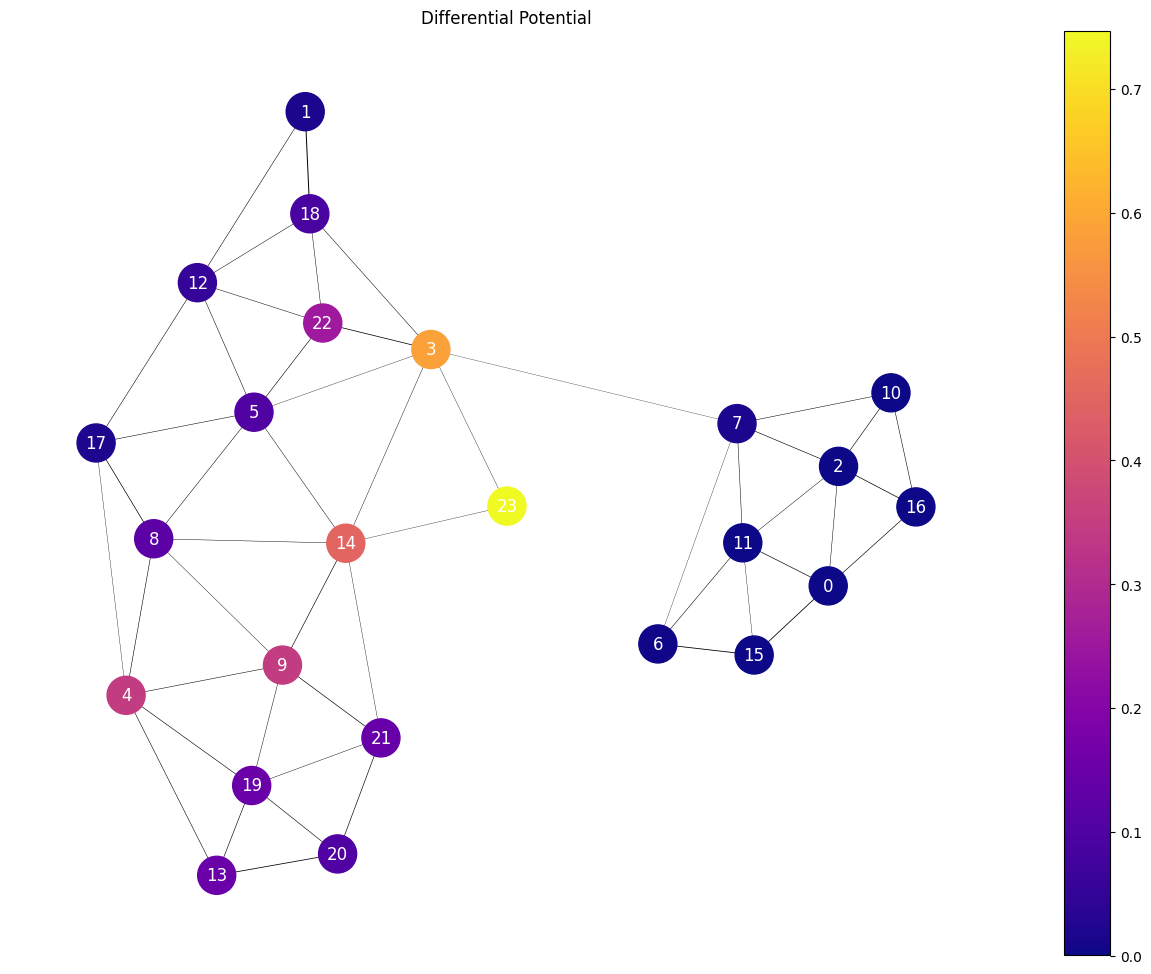

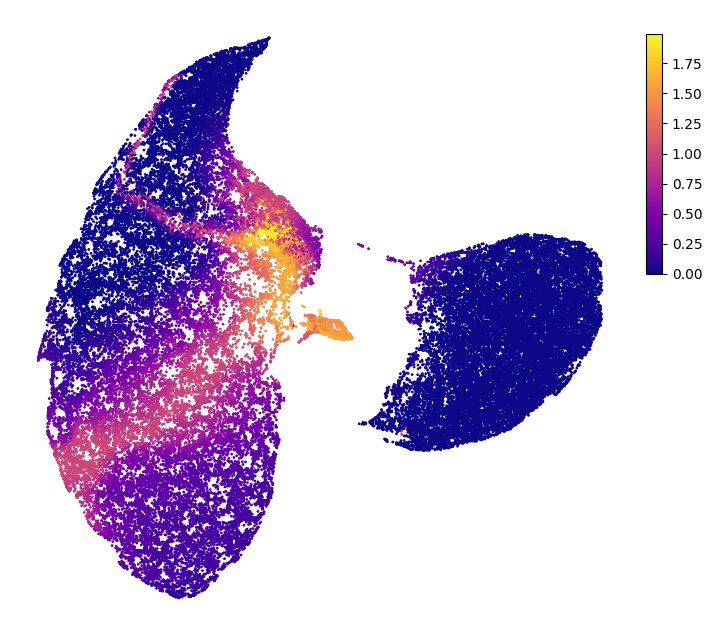

In [29]:
def plot_connectivity_graph_with_differential_potential(
    ad,
    cluster_connectivities,
    diff_potential,
    embedding_key="X_met_embedding",
    comm_key="metric_clusters",
    magic_key="X_magic",
    mode="undirected",
    cmap="YlGn",
    figsize=(16, 12),
    node_size=400,
    font_color="black",
    title=None,
    save_path=None,
    save_kwargs={},
    offset=0,
    **kwargs,
):
    try:
        X_embedded = ad.obsm[embedding_key]
    except KeyError:
        raise Exception(f"Key {embedding_key} not found in {ad}")

    try:
        communities = ad.obs[comm_key]
    except KeyError:
        raise Exception(f"Key {comm_key} not found in {ad}")

    try:
        X_imputed = pd.DataFrame(
            ad.obsm[magic_key], index=ad.obs_names, columns=ad.var_names
        )
    except KeyError:
        print("MAGIC imputed data not found. Using raw counts instead")
        X_imputed = ad.to_df()


    g, node_positions = compute_connectivity_graph(
        X_embedded, communities, cluster_connectivities, mode=mode
    )

    # Normalize and compute cluster wise mean expression of the gene
    X_gene = diff_potential
    X_gene = (X_gene - X_gene.min()) / (X_gene.max() - X_gene.min())
    gene_exprs = []
    for cluster_id in np.unique(communities):
        ids = communities == cluster_id
        mean_gene_expr = X_gene.loc[ids].mean()
        gene_exprs.append(mean_gene_expr)

    # Draw the graph
    plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    edge_weights = [offset + w for _, _, w in g.edges.data("weight")]
    nx.draw_networkx(
        g,
        pos=node_positions,
        cmap=cmap,
        node_color=gene_exprs,
        font_color=font_color,
        node_size=node_size,
        width=edge_weights,
        **kwargs,
    )
    # Setup color bar
    vmin = np.min(gene_exprs)
    vmax = np.max(gene_exprs)
    normalize = mp.colors.Normalize(vmin=vmin, vmax=vmax)
    cax, _ = mp.colorbar.make_axes(plt.gca())
    mp.colorbar.ColorbarBase(cax, norm=normalize, cmap=plt.get_cmap(cmap))

    if save_path is not None:
        plt.savefig(save_path, **save_kwargs)
    plt.show()    

plot_connectivity_graph_with_differential_potential(adata, un_connectivity, ent, font_color='white', \
        cmap='plasma', offset=0.2, node_size=750, font_size=12, comm_key='metric_clusters', 
                                                    title = "Differential Potential",
                                                    save_path='./Figures/beta_Run_10Mar/differential_potential.png',
                                                    save_kwargs={
                                                        'dpi': 300,
                                                        'bbox_inches': 'tight',
                                                        'transparent': True
                                                    })

# Plot the Differentiation potential
plot_embeddings(
    adata.obsm['X_met_embedding'],
    s=1,
    c=ent,
    figsize=(8, 8),
    cmap='plasma',
    show_colorbar=True,
    save_path='./Figures/beta_Run_10Mar/differential_potential_embedding.png',
    cb_axes_pos=[0.92, 0.55, 0.02, 0.3],
    save_kwargs={
        'dpi': 300,
        'bbox_inches': 'tight',
        'transparent': True
    }
)

## Feature Plot

In [30]:
factors = pd.read_csv(data_path + "Browse Transcription Factors mm9 - resource_browser.csv")

TFs = set(adata.var_names.to_list()).intersection(factors['Symbol'].to_list())

190
MAGIC imputed data not found. Using raw counts instead
Runtime for compute_connectivity_graph(): 0.02454972267150879


FileNotFoundError: [Errno 2] No such file or directory: './Figures/Run_10Mar/gene_expression/gene_expression_Ash1l.png'

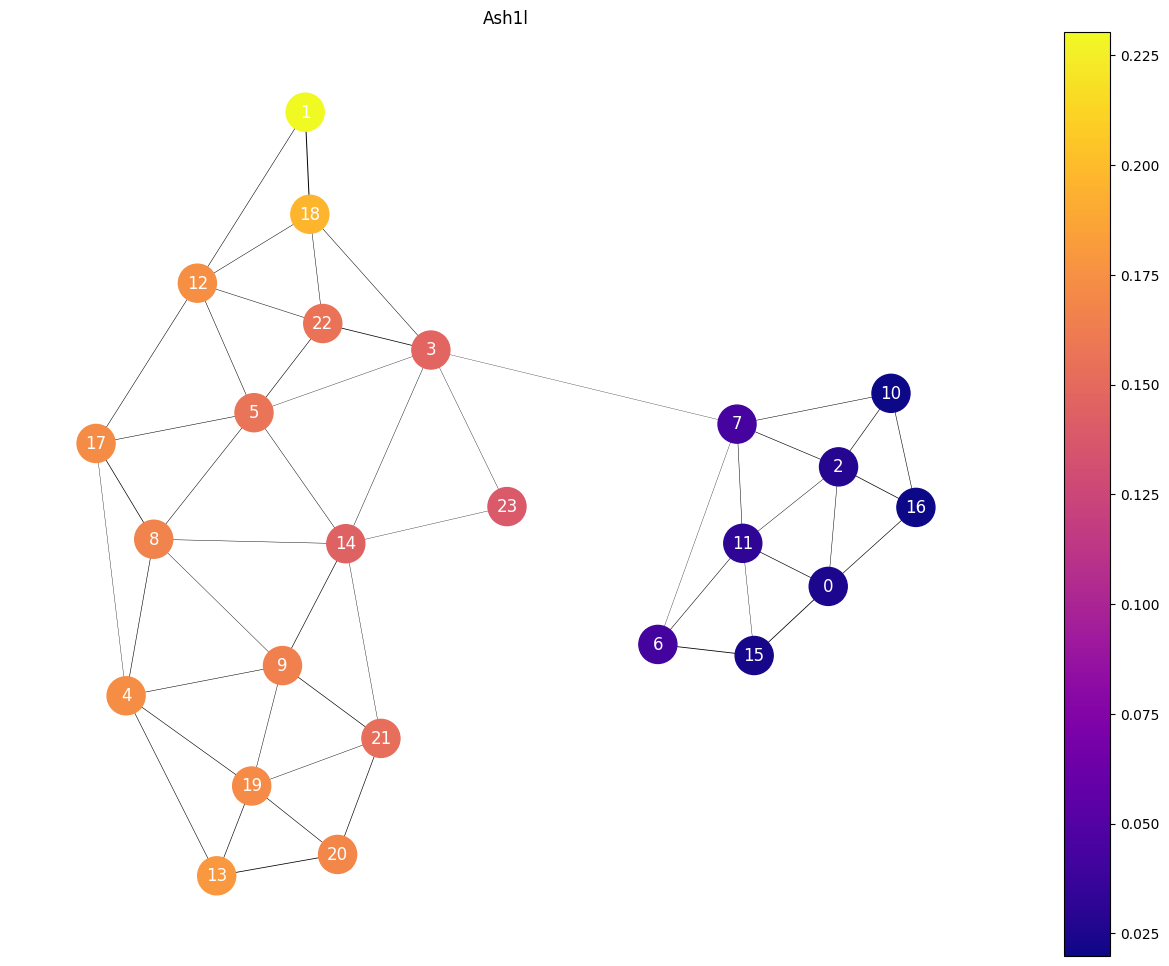

In [33]:
print (len(TFs))

for i in TFs:
    plot_connectivity_graph_with_gene_expressions(adata, un_connectivity, i, mode = "undirected", font_color='white', \
        cmap='plasma', offset=0.2, node_size=750, font_size=12, comm_key='metric_clusters', title = i,
        save_path = "./Figures/Run_10Mar/gene_expression/gene_expression_" + str(i) + ".png",
        save_kwargs={
            'dpi': 300,
            'transparent': True,
            'bbox_inches': 'tight'
        },)

In [ ]:
for i in beta1_Tfs:
    plot_connectivity_graph_with_gene_expressions(adata, un_connectivity, i, mode = "directed", font_color='white', \
        cmap='plasma', offset=0.2, node_size=750, font_size=12, comm_key='metric_clusters', title = i,
        save_path = "./Figures/beta_Run_10Mar/lineage_trend/using 4 terminal states/beta_1/gene_expression_" + str(i) + ".png",
        save_kwargs={
            'dpi': 300,
            'transparent': True,
            'bbox_inches': 'tight'
        },)
    
for i in beta2_Tfs:
    plot_connectivity_graph_with_gene_expressions(adata, un_connectivity, i, mode = "directed", font_color='white', \
        cmap='plasma', offset=0.2, node_size=750, font_size=12, comm_key='metric_clusters', title = i,
        save_path = "./Figures/beta_Run_10Mar/lineage_trend/using 4 terminal states/beta_2/gene_expression_" + str(i) + ".png",
        save_kwargs={
            'dpi': 300,
            'transparent': True,
            'bbox_inches': 'tight'
        },)
    
for i in beta3_Tfs:
    plot_connectivity_graph_with_gene_expressions(adata, un_connectivity, i,mode = "directed", font_color='white', \
        cmap='plasma', offset=0.2, node_size=750, font_size=12, comm_key='metric_clusters', title = i,
        save_path = "./Figures/beta_Run_10Mar/lineage_trend/using 4 terminal states/beta_3/gene_expression_" + str(i) + ".png",
        save_kwargs={
            'dpi': 300,
            'transparent': True,
            'bbox_inches': 'tight'
        },)
    

# Plot Lineage Trend

In [40]:
beta1_Tfs = ["Zhx1", "Vdr", "Tshz1","Tox3","Smad4","Pdx1","Nr3c1","Nr1d2","Npas3","Nkx6-1","Neurod1",
             "Ncoa1","Klf9","Klf3","Hlf","Foxf2","Etv1","Bach1","Atf5", 'Aff1']

beta2_Tfs = ["Tsc22d3","Mafa","Irx1","Dbp","Cebpd","Barhl1"]

beta3_Tfs = ["Zfp292","Zbtb20","Tcf4","Peg3","Pax6","Nfkbiz","Mef2c",
             "Mafb","Klf6","Jund","Junb","Jun","Isl1","Hivep3","Gata6","Gabpb2","Foxp1",
             "Fosb","Fos","Egr1","Dnmt3a","Dmtf1","Bptf","Barx2","Atrx","Ash1l"]

#0, 4, 5, 10, 12 
"""
ts_map = {
    10 : "Beta-1",
    0: "Beta-2",
    #4 : "Beta-2",
    #5 : "Beta-2",
    #0 : "Beta-2",
       12: "Beta-3"
}
"""

# 13->b beta1, 18-> 3, 6 -> 2
ts_map = {
    13: "Beta-1",
    1: "Beta-3",
    16: "Beta-2"
}

color_map_LT = {
    
0: "#5f0f40", 
1: "#0CB702",#"#9a031e", 
2:"#fb8b24", 
13: "#F8766D",#"#e36414", ##
4:"#0f4c5c", 
5:"#d62828", 
6:"#2a9d8f", ###
7:"#03045e", 
16:"#CD9600",#"#9b5de5", ### 
12:"#d62828"
    
}


In [41]:
# Plot lineage trends
comms = adata.obs['metric_clusters'].loc[bps.columns]
bps_ = pd.DataFrame(bps.to_numpy(), columns=list(comms), index=adata.obs_names)


In [42]:
print (bps_.columns, bps_)

Int64Index([1, 17, 16, 13], dtype='int64')                                       1         17        16        13
HFD-8W-1R_AAACCCAAGTACTGGG-1_1  0.004579  0.435786   0.23087  0.328765
HFD-8W-1R_AAACCCAGTACACGCC-1_1  0.005835  0.456266  0.189487  0.348411
HFD-8W-1R_AAAGGATCAAGTTCGT-1_1   0.00781  0.253447  0.505821  0.232922
HFD-8W-1R_AAAGGTATCGCCGATG-1_1  0.005143  0.463693  0.180773  0.350391
HFD-8W-1R_AAAGTCCTCCGTGGCA-1_1   0.01206  0.404999  0.273701  0.309239
...                                  ...       ...       ...       ...
RC-30W-3R_CTGCCTATCTCGGTAA-1    0.997584       0.0  0.002416       0.0
RC-30W-3R_TATCGCCTCTGAATGC-1    0.000015  0.999958       0.0  0.000028
RC-30W-3R_TATCTGTTCACACCGG-1    0.997501       0.0  0.002499       0.0
RC-30W-3R_TGAGCGCTCAGGGTAG-1    0.972809       0.0  0.027191       0.0
RC-30W-3R_TTTCATGGTTGACTAC-1    0.547128  0.053959  0.396268  0.002644

[64306 rows x 4 columns]


In [43]:
"""
# below lines code are subject to each run.

bps_new = bps_.copy()
bps_new[0] = bps_[0] + bps_[5] + bps_[4]
del (bps_new[5], bps_new[4])
"""

bps_new = bps_.copy()

bps_new[13] = (bps_new[13] + bps_new[17])# + bps_new[22])

In [44]:
#bps_new = bps_.copy()
del (bps_new[17]) #, bps_new[22])
print (bps_new)

                                      1         16        13
HFD-8W-1R_AAACCCAAGTACTGGG-1_1  0.004579   0.23087  0.764551
HFD-8W-1R_AAACCCAGTACACGCC-1_1  0.005835  0.189487  0.804677
HFD-8W-1R_AAAGGATCAAGTTCGT-1_1   0.00781  0.505821  0.486369
HFD-8W-1R_AAAGGTATCGCCGATG-1_1  0.005143  0.180773  0.814084
HFD-8W-1R_AAAGTCCTCCGTGGCA-1_1   0.01206  0.273701  0.714238
...                                  ...       ...       ...
RC-30W-3R_CTGCCTATCTCGGTAA-1    0.997584  0.002416       0.0
RC-30W-3R_TATCGCCTCTGAATGC-1    0.000015       0.0  0.999985
RC-30W-3R_TATCTGTTCACACCGG-1    0.997501  0.002499       0.0
RC-30W-3R_TGAGCGCTCAGGGTAG-1    0.972809  0.027191       0.0
RC-30W-3R_TTTCATGGTTGACTAC-1    0.547128  0.396268  0.056604

[64306 rows x 3 columns]


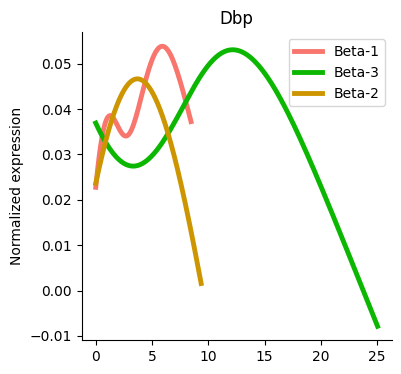

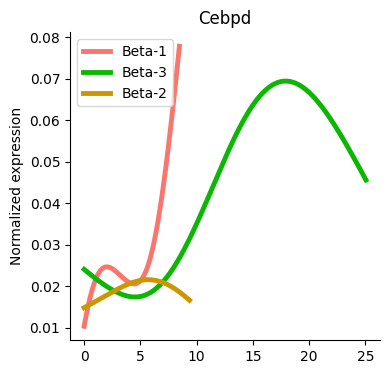

In [46]:
def plot_lineage_trends(
    ad,
    cell_branch_probs,
    genes,
    pseudotime_key="metric_pseudotime",
    imputed_key=None,
    nrows=1,
    figsize=None,
    norm=True,
    threshold=0.95,
    show_title=False,
    save_path=None,
    ts_map=None,
    color_map=None,
    save_kwargs={},
    gam_kwargs={},
    **kwargs,
):
    t_states = cell_branch_probs.columns
    pt = ad.obs[pseudotime_key]

    data_ = ad.X
    if imputed_key is not None:
        data_ = ad.obsm[imputed_key]

    if isinstance(data_, scipy.sparse.csr_matrix):
        data_ = data_.todense()

    if norm:
        # Min-max normalization
        data_ = (data_ - np.min(data_, axis=0)) / (
            np.max(data_, axis=0) - np.min(data_, axis=0)
        )

    data_df = pd.DataFrame(data_, columns=ad.var_names, index=ad.obs_names)
    ncols = math.ceil(len(genes) / nrows)
    fig, ax = plt.subplots(
        nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize
    )
    gene_idx = 0

    # Compute lineage expression trends for each gene
    for row_idx in range(nrows):
        for col_idx in range(ncols):
            if nrows == 1 and ncols == 1:
                axes = ax
            elif nrows == 1:
                axes = ax[col_idx]
            elif ncols == 1:
                axes = ax[row_idx]
            else:
                axes = ax[row_idx, col_idx]

            gene_exp = data_df.loc[:, genes[gene_idx]]
            for i in ts_map.keys():#[0, 10, 12]: #t_states:
                # Get the val set
                loc_i = np.where(cell_branch_probs.loc[:, i] > threshold)[0]
                if loc_i.shape[0] == 0:
                    continue
                val_pt = pt[loc_i]
                max_val_pt = max(val_pt)

                # Fit GAM
                # NOTE: GAM Code inspired from https://github.com/ShobiStassen/VIA
                loc_i_bp = np.where(cell_branch_probs.loc[:, i] > 0)[0]
                x = np.asarray(pt)[loc_i_bp].reshape(-1, 1)
                y = np.asarray(gene_exp)[loc_i_bp].reshape(-1, 1)
                weights = np.asarray(cell_branch_probs.loc[:, i])[loc_i_bp].reshape(
                    -1, 1
                )
                geneGAM = pg.LinearGAM(
                    n_splines=10, spline_order=4, lam=10, **gam_kwargs
                ).fit(x, y, weights=weights)

                # Eval GAM
                nx_spacing = 100
                xval = np.linspace(0, max_val_pt, nx_spacing * 2)
                yg = geneGAM.predict(X=xval)

                # Plot
                ts_label = ts_map[i] if ts_map is not None else i
                if color_map is not None:
                    kwargs["color"] = color_map[i]

                # Remove the right and top axes
                axes.spines["right"].set_visible(False)
                axes.spines["top"].set_visible(False)
                # axes.set_ylim([0, 1])
                axes.plot(xval, yg, linewidth=3.5, zorder=3, label=ts_label, **kwargs)
            axes.set_ylabel("Normalized expression")
            axes.legend()

            if show_title:
                plt.title(genes[gene_idx])
            gene_idx += 1

    if save_path is not None:
        plt.savefig(save_path, **save_kwargs)
    plt.show()

for i in beta2_Tfs:
    
    plot_lineage_trends(
        adata,
        bps_new,
        [i], #gene_list,"Pax6","Foxa2", 
        pseudotime_key='metric_pseudotime_v2',
        figsize=(4, 4),
        #imputed_key='X_magic',
        nrows=1,#len(alpha1_Tfs),#2,
        norm=True,
        threshold=0.95,
        ts_map=ts_map,
        save_path='./Figures/beta_Run_10Mar/lineage_trend/beta_2/lineage_' + i + '.png',
        save_kwargs={
            'dpi': 300,
            'bbox_inches': 'tight',
            'transparent': True
        },
        color_map=color_map_LT,
        show_title = True
        # threshold=0
    )


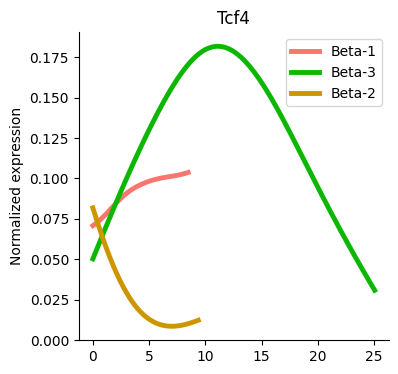

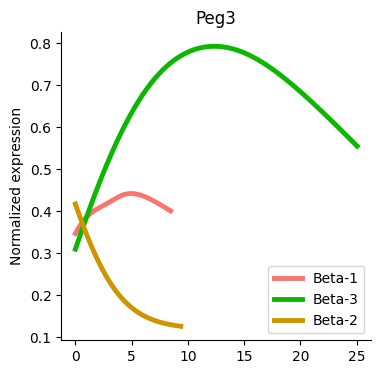

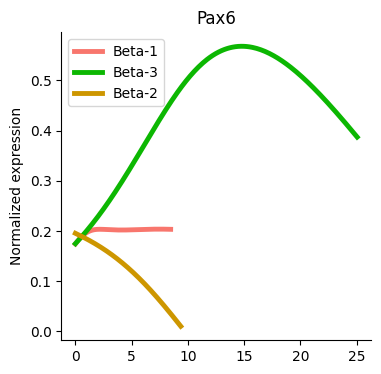

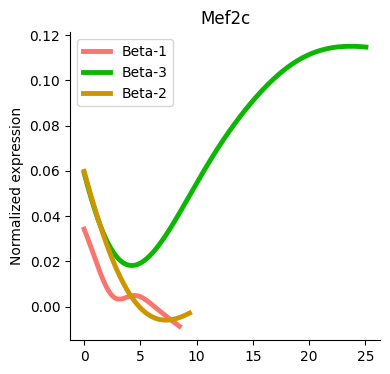

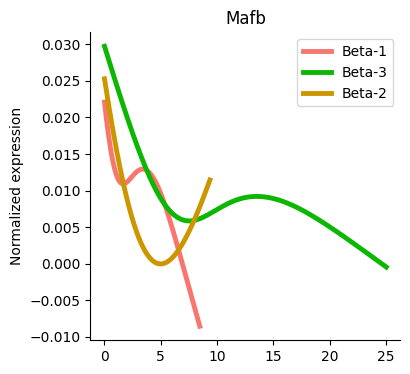

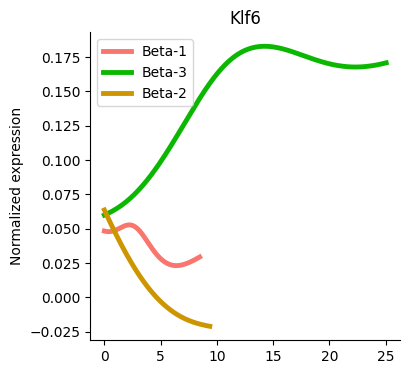

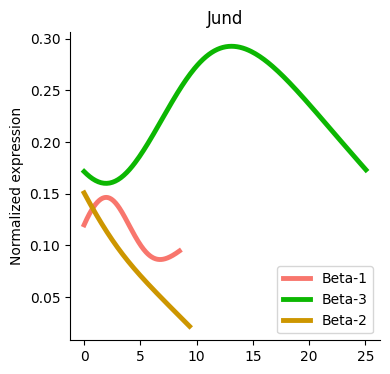

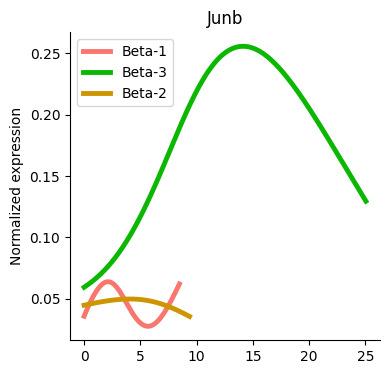

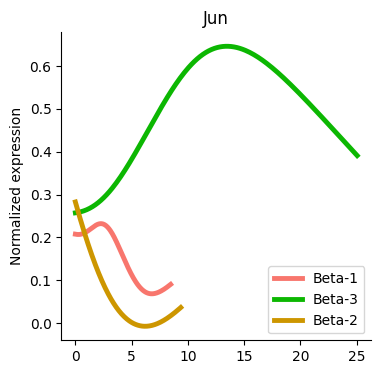

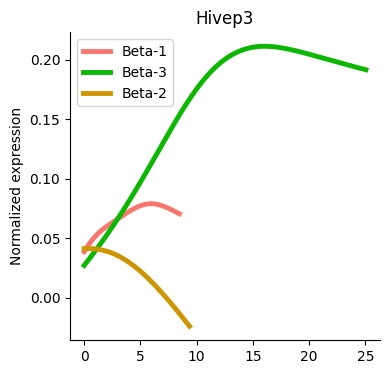

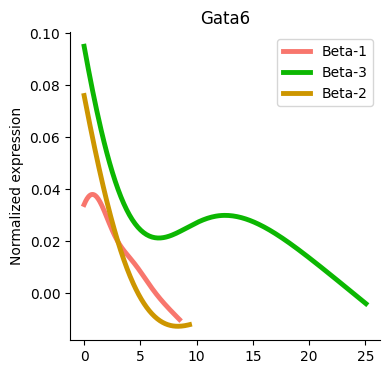

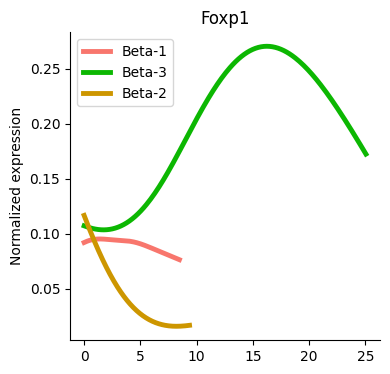

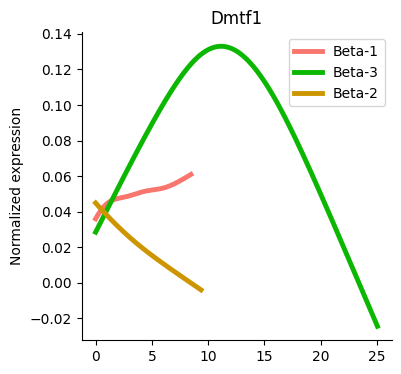

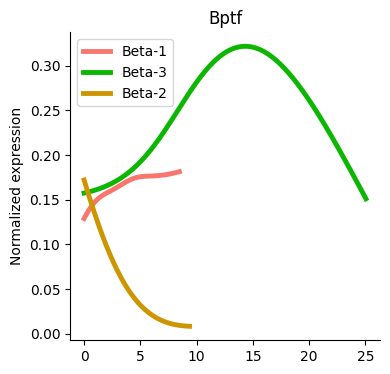

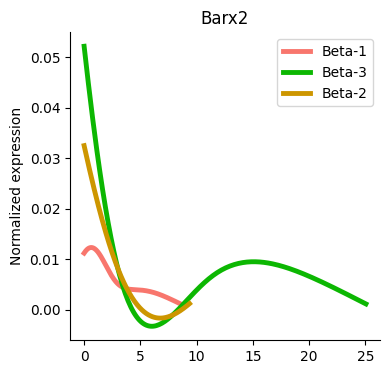

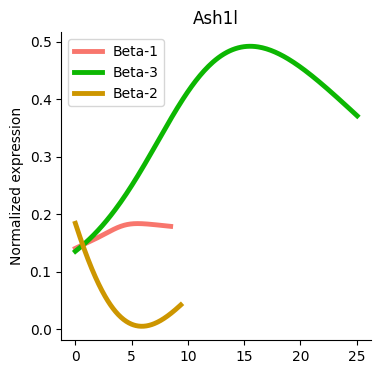

In [47]:
for i in beta3_Tfs:
    
    plot_lineage_trends(
        adata,
        bps_new,
        [i], #gene_list,"Pax6","Foxa2", 
        pseudotime_key='metric_pseudotime_v2',
        figsize=(4, 4),
        #imputed_key='X_magic',
        nrows=1,#len(alpha1_Tfs),#2,
        norm=True,
        threshold=0.95,
        ts_map=ts_map,
        save_path='./Figures/beta_Run_10Mar/lineage_trend/beta_3/lineage_' + i + '.png',
        save_kwargs={
            'dpi': 300,
            'bbox_inches': 'tight',
            'transparent': True
        },
        color_map=color_map_LT,
        show_title = True
        # threshold=0
    )

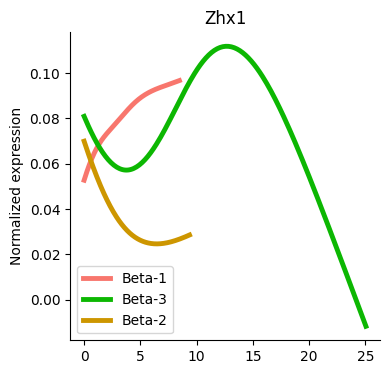

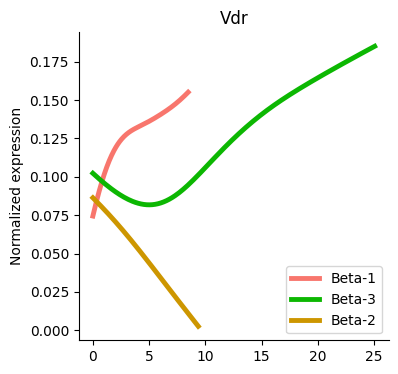

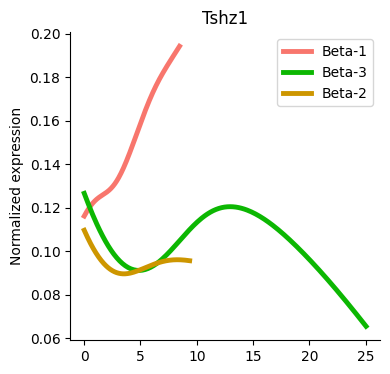

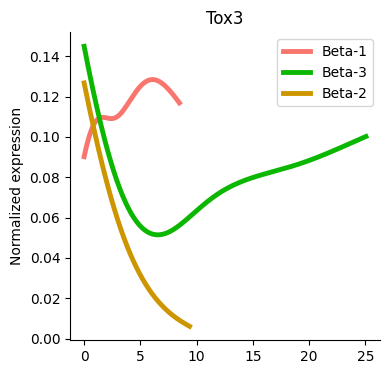

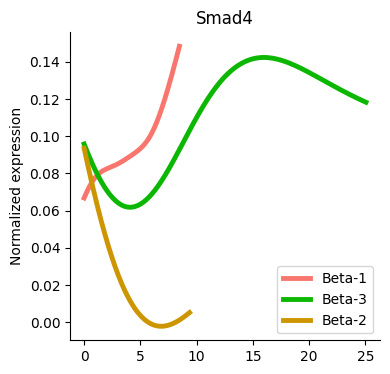

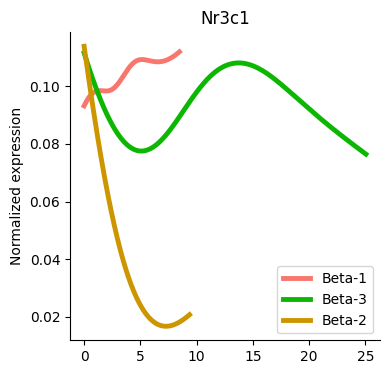

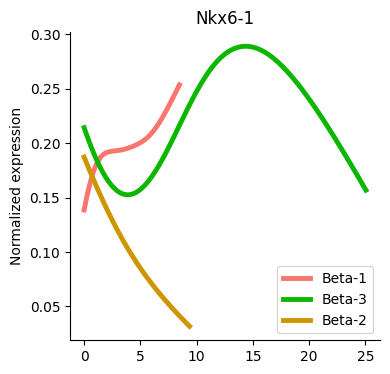

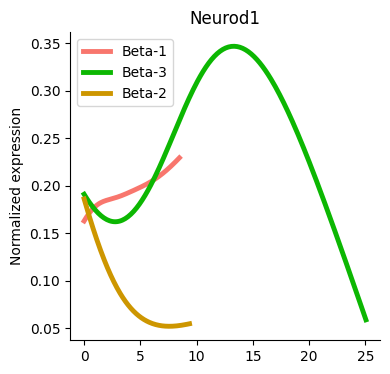

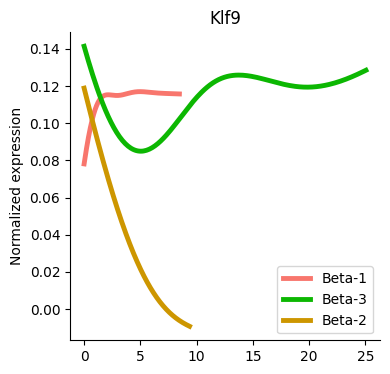

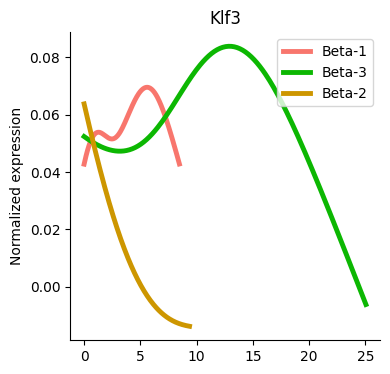

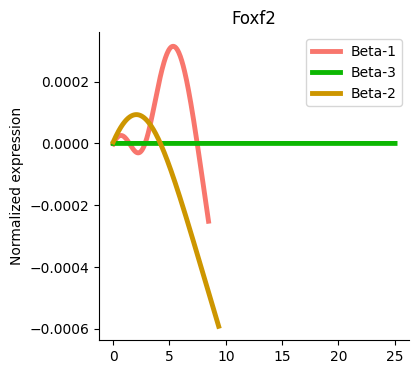

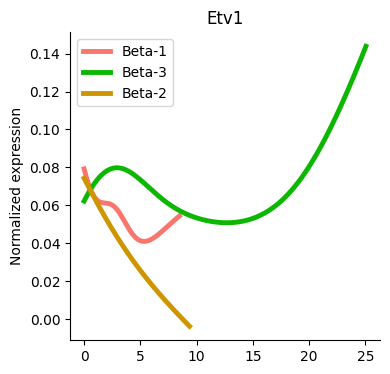

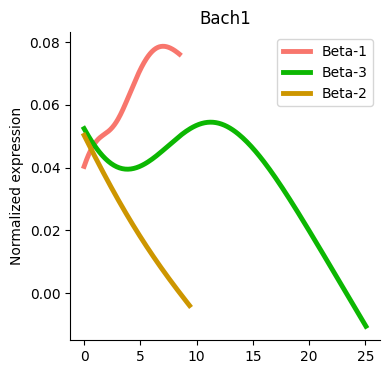

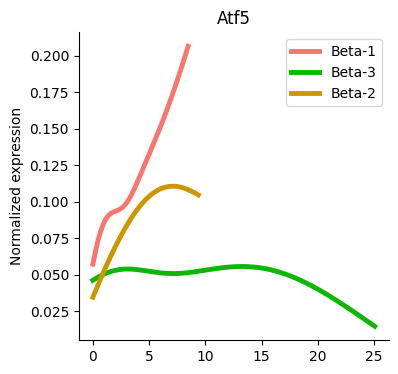

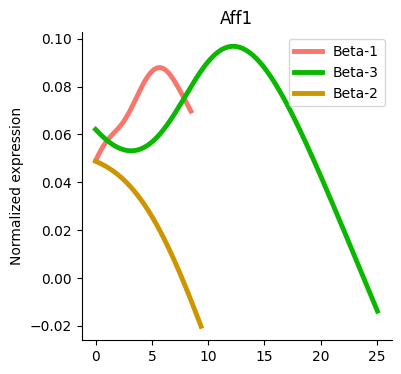

In [48]:

for i in beta1_Tfs:
    
    plot_lineage_trends(
        adata,
        bps_new,
        [i], #gene_list,"Pax6","Foxa2", 
        pseudotime_key='metric_pseudotime_v2',
        figsize=(4, 4),
        #imputed_key='X_magic',
        nrows=1,#len(alpha1_Tfs),#2,
        norm=True,
        threshold=0.95,
        ts_map=ts_map,
        save_path='./Figures/beta_Run_10Mar/lineage_trend/beta_1/lineage_' + i + '.png',
        save_kwargs={
            'dpi': 300,
            'bbox_inches': 'tight',
            'transparent': True
        },
        color_map=color_map_LT,
        show_title = True
        # threshold=0
    )
